In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [27]:
# Define dataset
DATASET_DIR = Path("dataset")

files = {
    "breast":   "breast_cancer_cleaned.csv",
    "diabetes": "diabetes_cleaned.csv",
    "kidney":   "kidney_disease_cleaned.csv",
    "heart":    "dataR2_cleaned.csv",
}

In [28]:

def smart_load(name, fn):
    f_path = DATASET_DIR / fn
    if f_path.exists():
        return pd.read_csv(f_path)
    matches = list(DATASET_DIR.rglob(f"*{Path(fn).stem}*"))
    if matches:
        print(f"Found file for '{name}' via glob: {matches[0]}")
        return pd.read_csv(matches[0])
    print(f"WARNING: Could not find file for '{name}' ({f_path.name}), returning empty DataFrame.")
    return pd.DataFrame()

dfs = {k: smart_load(k, v) for k, v in files.items()}

for k, df in dfs.items():
    print(f"{k}: shape={df.shape}")
    display(df.head(2))

breast: shape=(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


diabetes: shape=(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


kidney: shape=(400, 26)


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.02,1.0,0.0,normal,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.02,4.0,0.0,normal,normal,notpresent,notpresent,...,38,6000,5.2,no,no,no,good,no,no,ckd


heart: shape=(116, 10)


,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1


In [29]:
# Breast label mapping
if not dfs["breast"].empty:
    if "Unnamed: 32" in dfs["breast"].columns and dfs["breast"]["Unnamed: 32"].isna().all():
        dfs["breast"] = dfs["breast"].drop(columns=["Unnamed: 32"])
    print(f"Breast diagnosis unique: {dfs['breast']['diagnosis'].unique()}")
    dfs["breast"]["diagnosis"] = dfs["breast"]["diagnosis"].astype(str).str.strip().str.upper()
    print(f"Breast diagnosis unique after strip+upper: {dfs['breast']['diagnosis'].unique()}")
    dfs["breast"]["diagnosis"] = dfs["breast"]["diagnosis"].map({"M": 1, "B": 0})
    print("Breast label counts after mapping:", dfs["breast"]["diagnosis"].value_counts(dropna=False))

Breast diagnosis unique: ['M' 'B']
Breast diagnosis unique after strip+upper: ['M' 'B']
Breast label counts after mapping: diagnosis
0    357
1    212
Name: count, dtype: int64


In [30]:
# Diabetes: ensure all ints
if not dfs["diabetes"].empty:
    dfs["diabetes"]["Outcome"] = pd.to_numeric(dfs["diabetes"]["Outcome"], errors="coerce")
    print("Diabetes Outcome counts:", dfs["diabetes"]["Outcome"].value_counts(dropna=False))


Diabetes Outcome counts: Outcome
0    500
1    268
Name: count, dtype: int64


In [31]:
# Heart label mapping
if not dfs["heart"].empty:
    dfs["heart"]["Classification"] = dfs["heart"]["Classification"].replace({1:0, 2:1})
    print("Heart Classification counts:", dfs["heart"]["Classification"].value_counts(dropna=False))


Heart Classification counts: Classification
1    64
0    52
Name: count, dtype: int64


In [32]:
# Kidney target (classification if exists, else cad)
kidney_target = None
if not dfs["kidney"].empty:
    kidney_target = "classification" if "classification" in dfs["kidney"].columns else ("cad" if "cad" in dfs["kidney"].columns else None)
    if kidney_target == "classification":
        dfs["kidney"][kidney_target] = dfs["kidney"][kidney_target].astype(str).str.strip().str.lower().map(
            {"ckd":1, "notckd":0, "no_ckd":0, "1":1, "0":0, "yes":1, "no":0}
        )
    elif kidney_target == "cad":
        dfs["kidney"][kidney_target] = dfs["kidney"][kidney_target].astype(str).str.strip().str.lower().map(
            {"yes":1, "no":0, "y":1, "n":0}
        )
    if kidney_target:
        print("Kidney label counts:", dfs["kidney"][kidney_target].value_counts(dropna=False))
    else:
        print("No valid target found for kidney.")
else:
    print("Kidney DataFrame is empty.")

Kidney label counts: classification
1    250
0    150
Name: count, dtype: int64


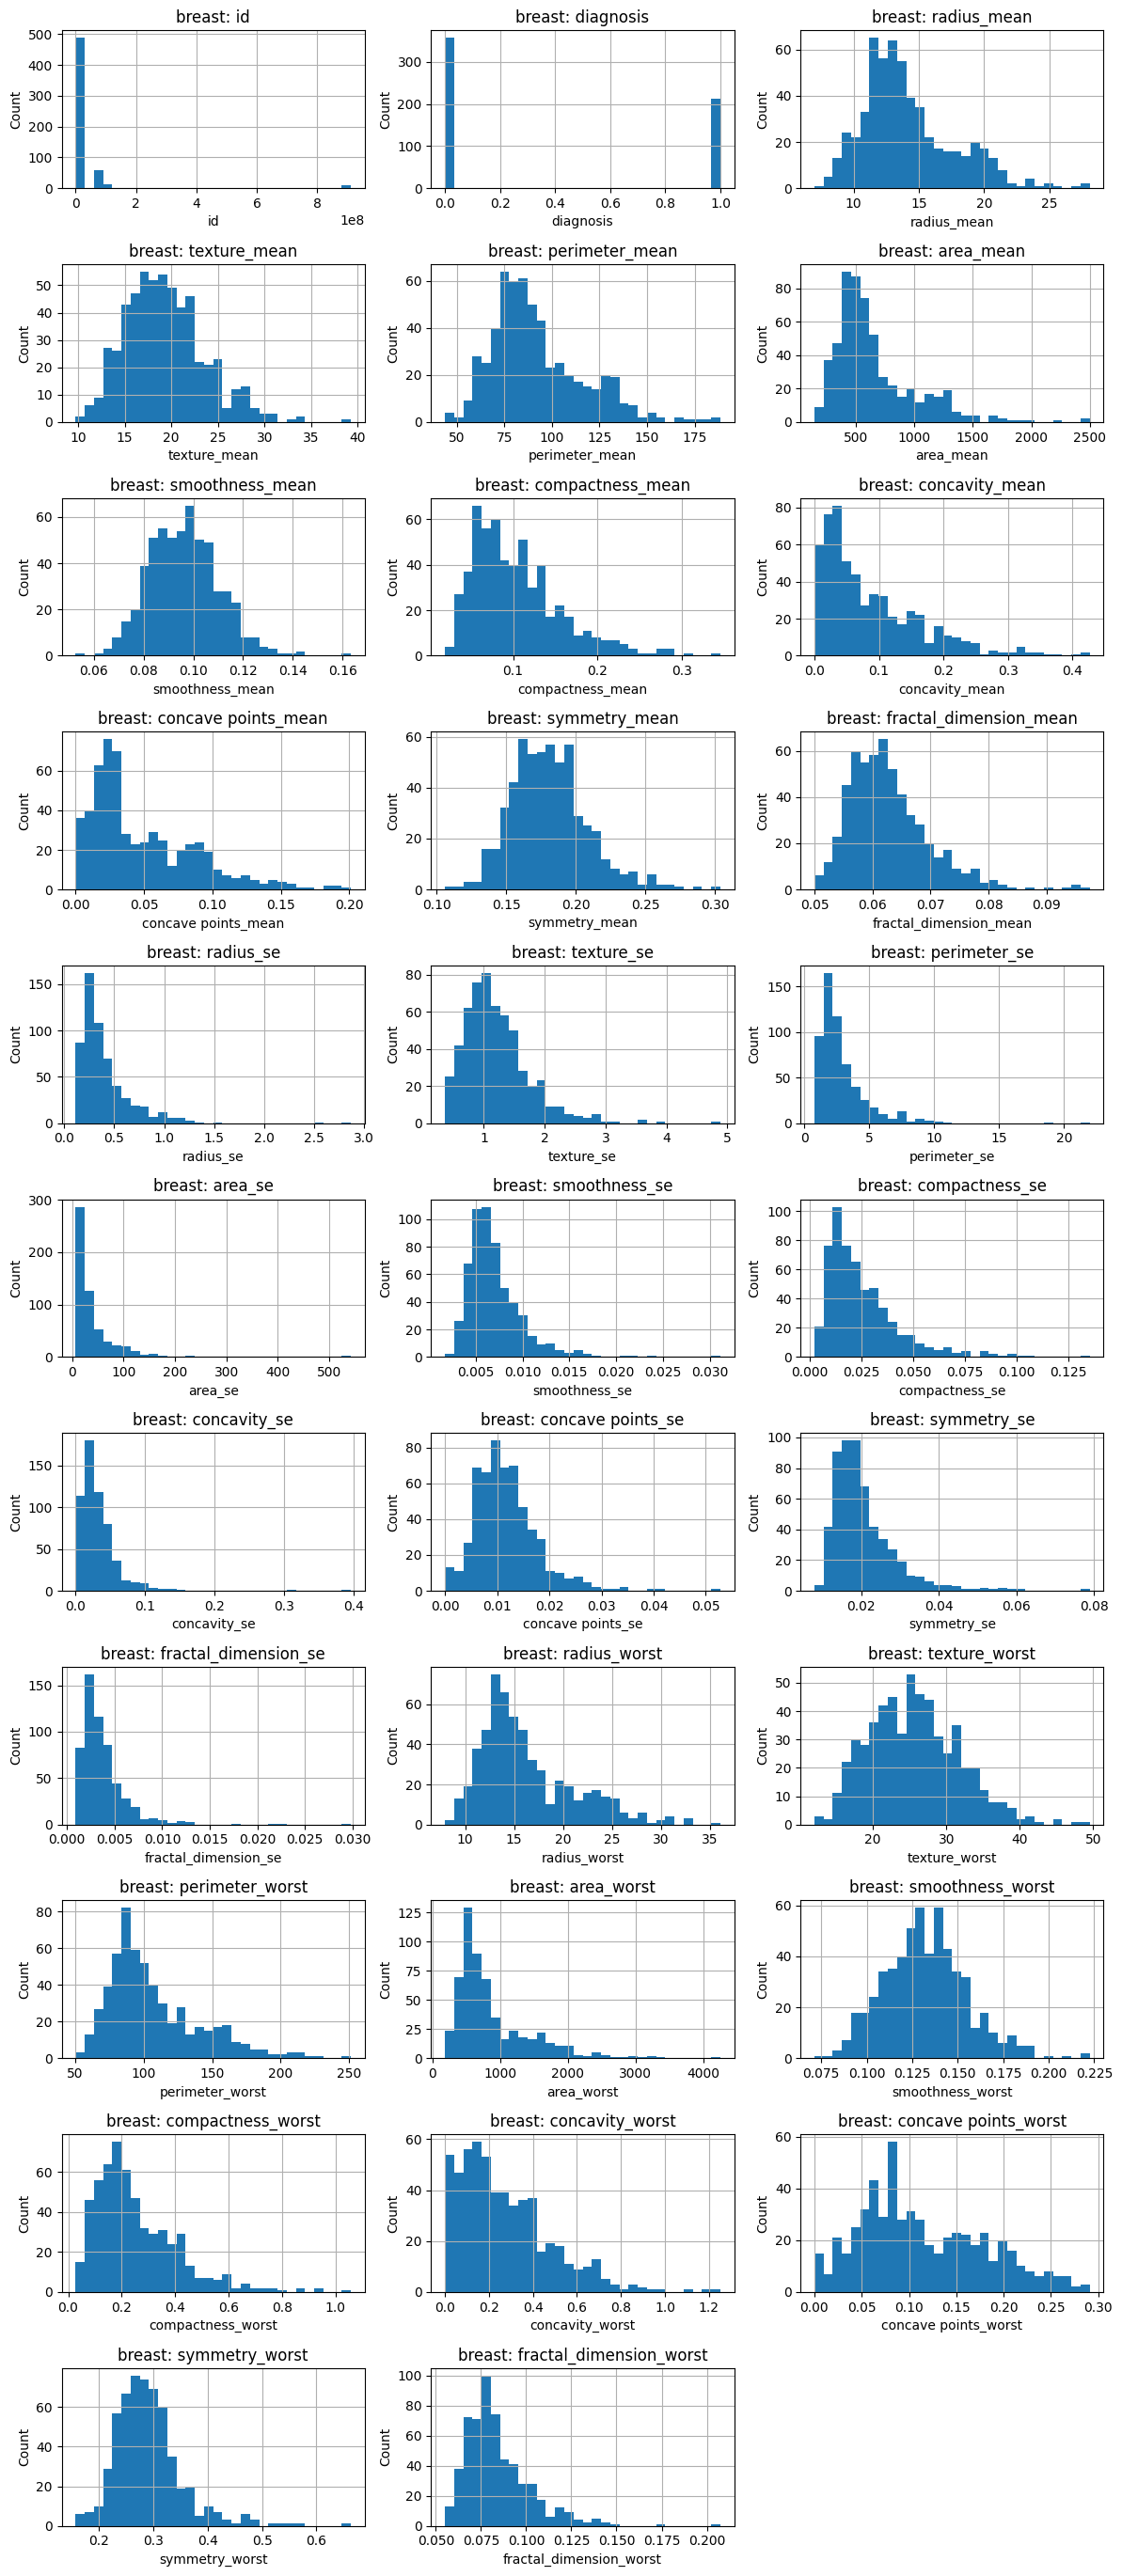

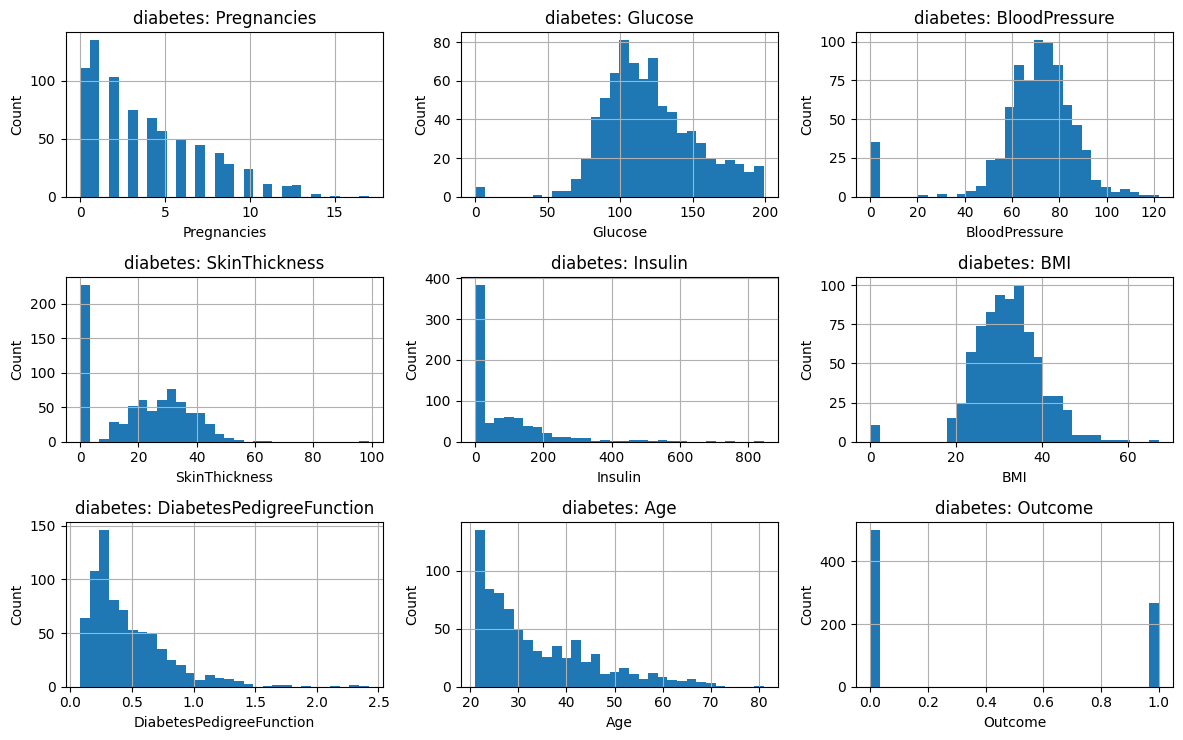

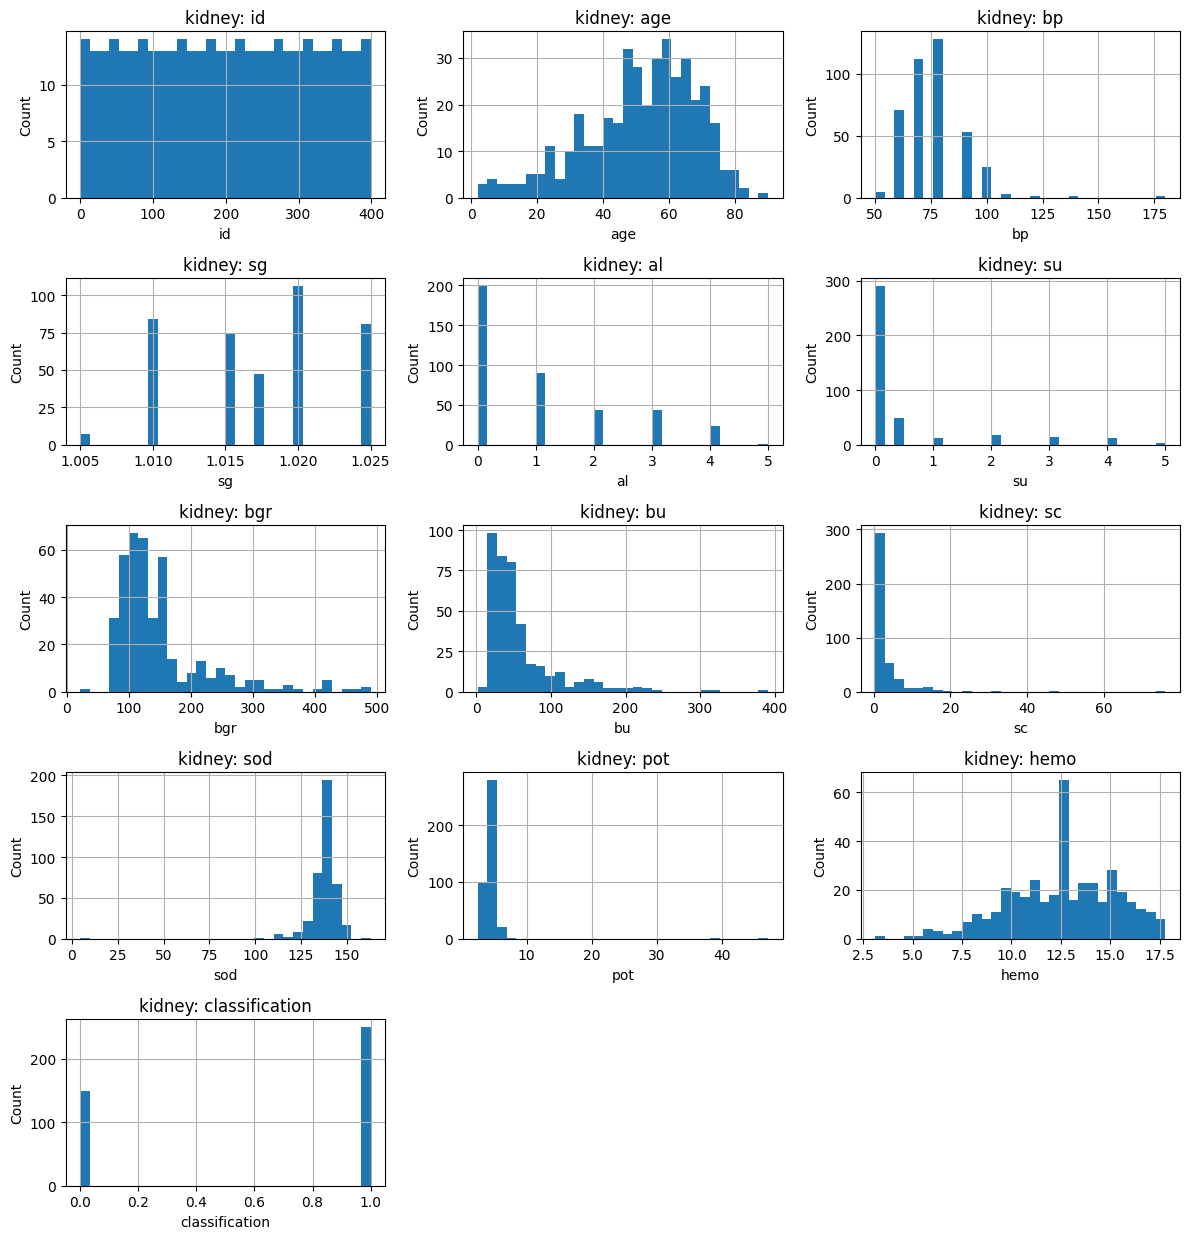

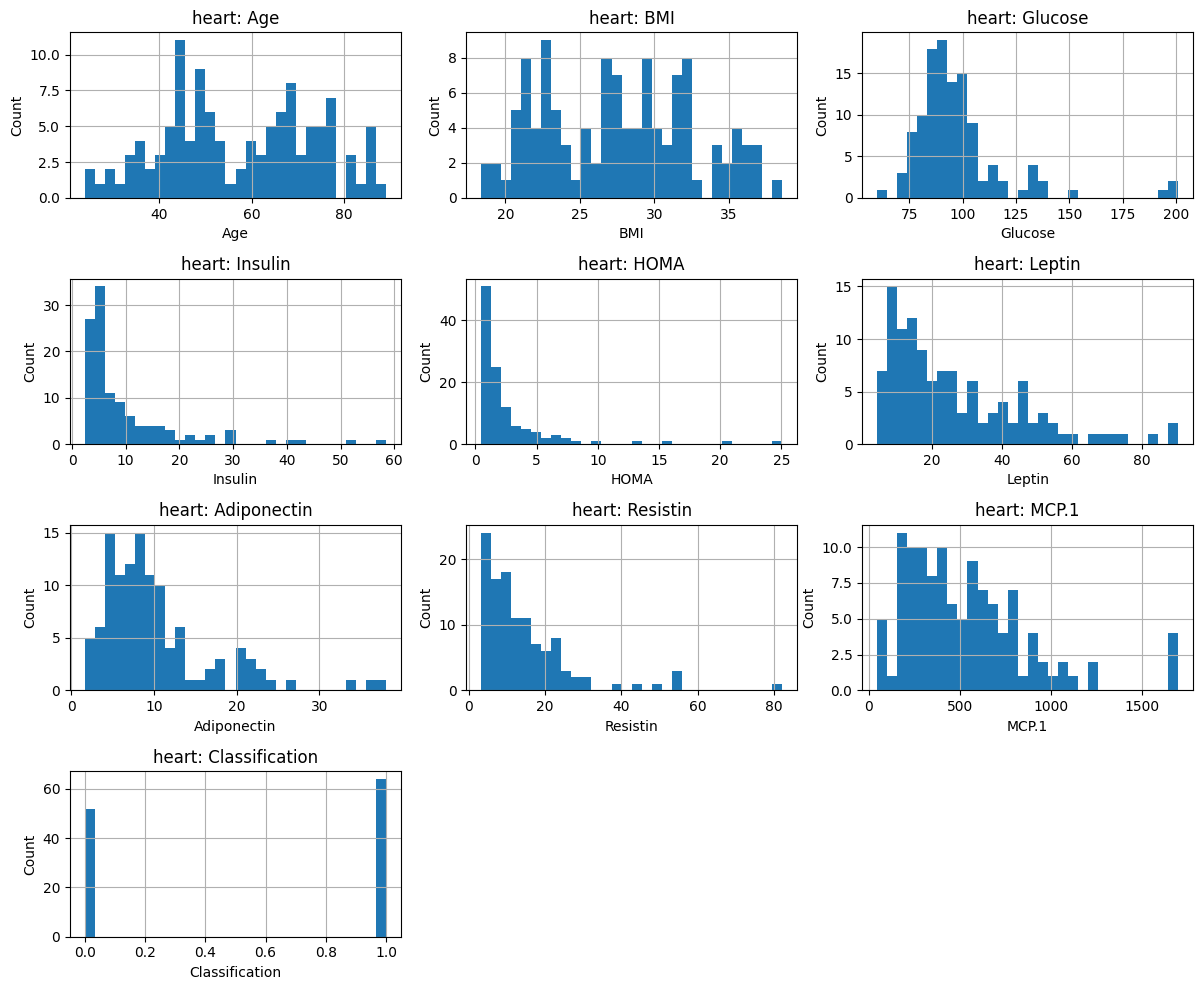

In [33]:
# Plot histograms
for k, df in dfs.items():
    if df.empty:
        print(f"{k}: Empty, skipping plot.")
        continue
    num_cols = df.select_dtypes(include=[np.number]).columns
    if not len(num_cols):
        print(f"{k}: No numeric columns to plot.")
        continue
    ncols = 3
    nrows = int(np.ceil(len(num_cols) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 2.5*nrows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    for i, col in enumerate(num_cols):
        ax = axes[i]
        df[col].hist(ax=ax, bins=30)
        ax.set_title(f"{k}: {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

In [34]:
# Define datasets dict
datasets = {
    "breast": (dfs["breast"], "diagnosis"),
    "diabetes": (dfs["diabetes"], "Outcome"),
    "heart": (dfs["heart"], "Classification"),
    "kidney": (dfs["kidney"], kidney_target) if kidney_target else (dfs["kidney"], None),
}

In [35]:

# Check label distributions and print unique classes for each task
for task, (df, ycol) in datasets.items():
    if ycol and not df.empty:
        print(f"{task} label counts:\n{df[ycol].value_counts(dropna=False)}")
        print(f"{task} unique values: {df[ycol].unique()}\n")

breast label counts:
diagnosis
0    357
1    212
Name: count, dtype: int64
breast unique values: [1 0]

diabetes label counts:
Outcome
0    500
1    268
Name: count, dtype: int64
diabetes unique values: [1 0]

heart label counts:
Classification
1    64
0    52
Name: count, dtype: int64
heart unique values: [0 1]

kidney label counts:
classification
1    250
0    150
Name: count, dtype: int64
kidney unique values: [1 0]



In [36]:

# Only split if EVERY df has at least 2 classes
splitting_ok = True
for task, (df, ycol) in datasets.items():
    if not ycol or df.empty:
        print(f"Skipping {task}, no target or empty df.")
        continue
    nunique = df[ycol].dropna().nunique()
    if nunique < 2:
        print(f"Error: {task} only has one class ({df[ycol].unique()})! Fix labels before splitting.")
        splitting_ok = False

ART = Path("artifacts")
ART.mkdir(exist_ok=True)

if splitting_ok:
    for task, (df, ycol) in datasets.items():
        if not ycol or df.empty:
            continue
        y = df[ycol].fillna(0).astype(int)
        X = df.drop(columns=[ycol])
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
        )
        X_tr, X_ca, y_tr, y_ca = train_test_split(
            X_train, y_train, test_size=0.25, stratify=y_train, random_state=RANDOM_SEED
        )
        tr = X_tr.copy(); tr[ycol] = y_tr; tr.to_csv(ART/f"{task}_train.csv", index=False)
        ca = X_ca.copy(); ca[ycol] = y_ca; ca.to_csv(ART/f"{task}_calib.csv", index=False)
        te = X_test.copy(); te[ycol] = y_test; te.to_csv(ART/f"{task}_test.csv", index=False)
        print(f"{task}: Wrote train/calib/test splits.")

    with open(ART/"meta.json", "w") as f:
        json.dump({
            "targets": {
                "breast": "diagnosis",
                "diabetes": "Outcome",
                "heart": "Classification",
                "kidney": kidney_target
            }
        }, f)
    print("Splits and targets saved to artifacts/")
else:
    print("Splitting not done. Fix label mapping first.")

breast: Wrote train/calib/test splits.
diabetes: Wrote train/calib/test splits.
heart: Wrote train/calib/test splits.
kidney: Wrote train/calib/test splits.
Splits and targets saved to artifacts/
